In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import pickle



In [2]:
class tilecoding:
  def __init__(self, env, num_tile, bins):
    self.env = env
    self.obs_dim = env.observation_space.shape[0]
    self.bins = bins
    self.num_tile = num_tile
    self.numTiles = (self.bins**self.obs_dim) * self.num_tile


  def tiles_grid(self, offset_pos):
    min_pos, min_vel, min_angle, min_v_angle = self.env.observation_space.low
    max_pos, max_vel, max_angle, max_v_angle = self.env.observation_space.high
    bins = self.bins

    pos_grid =  np.linspace(min_pos, max_pos, bins )[1:-1] +  offset_pos[0]#np.concatenate((np.array([min_pos]), np.linspace(-2, 2, bins)[0:-1], np.array([max_pos])))
    angle_grid = np.linspace(min_angle, max_angle, bins )[1:-1] + + offset_pos[2] #np.concatenate((np.array([min_angle]), np.linspace(-0.3, 0.3, bins)[0:-1], np.array([max_angle])))
    vel_grid = np.concatenate((np.array([min_vel]), np.linspace(-5, 5, bins)[2:-2], np.array([max_vel])))+ offset_pos[1]
    angle_vel_grid = np.concatenate((np.array([-9999]), np.linspace(-5, 5, bins)[2:-2], np.array([9999]))) + + offset_pos[3]
    grid = [pos_grid, vel_grid, angle_grid, angle_vel_grid ]
    return grid #np.array(grid).flatten()
  
  def create_tilings(self):
    high = np.array([2.5, 5, 0.42, 5])
    low = np.array([-2.5, -5, -0.42, -5])
    offset_pos = (high - low)/(self.num_tile*self.bins)
    n = self.num_tile // 2
    num = -n*offset_pos
    #print(num)
    tiling_specs = [-n*offset_pos]
    for i in range(self.num_tile - 1):
      num += offset_pos
      #print(num)
      tiling_specs.append(num)

    
    #tiling_specs = [-offset_pos, tuple([0.0]*self.env.observation_space.shape[0]), offset_pos]
    #print([print(offsets) for offsets in tiling_specs])
    return [self.tiles_grid(offsets) for offsets in tiling_specs]

  def discretize(self, obs, tile_grid):
    encode = []
    for grids in tile_grid:
      #tile_grid = np.array(tile_grid).reshape(self.obs_dim, -1)
      position_tuple = tuple(int(np.digitize(state, grid)) for state, grid in zip(obs, grids))
      #print(position_tuple)
      array = []
      for i in range(self.obs_dim):
        state = [0]*self.bins
        state[position_tuple[i] - 1] = 1
        array.append(state)
      encode.append(array)
    return np.array(encode).flatten()


class tilecoding_Mountain:
  def __init__(self, env, num_tile, bins):
    self.env = env
    self.obs_dim = env.observation_space.shape[0]
    self.bins = bins
    self.num_tile = num_tile
    #bins = tuple([bins]*env.observation_space.shape[0])
    self.numTiles = (self.bins**self.obs_dim) * self.num_tile


  def tiles_grid(self, offset_pos):
    #print(offset_pos)
    min_pos, min_vel  = self.env.observation_space.low
    max_pos, max_vel = self.env.observation_space.high
    bins = self.bins

    pos_grid =  np.linspace(min_pos, max_pos, bins + 1)[1:-1] + offset_pos[0]
    vel_grid = np.linspace(min_vel, max_vel, bins + 1)[1:-1] + offset_pos[1]

    grid = [pos_grid, vel_grid]
    return grid #np.array(grid).flatten()
  
  def create_tilings(self):
    offset_pos = (self.env.observation_space.high - self.env.observation_space.low)/(self.num_tile*self.bins)
    n = self.num_tile // 2
    num = -n*offset_pos
    tiling_specs = [-n*offset_pos]
    for i in range(self.num_tile - 1):
      num += offset_pos
      tiling_specs.append(num)

    
    #tiling_specs = [-offset_pos, tuple([0.0]*self.env.observation_space.shape[0]), offset_pos]
    #print(tiling_specs)

    return [self.tiles_grid(offsets) for offsets in tiling_specs]

  def discretize(self, obs, tile_grid):
    encode = []
    for grids in tile_grid:
      #tile_grid = np.array(tile_grid).reshape(self.obs_dim, -1)
      position_tuple = tuple(int(np.digitize(state, grid)) for state, grid in zip(obs, grids))
      #print(position_tuple)
      array = []
      for i in range(self.obs_dim):
        state = [0]*self.bins
        state[position_tuple[i] - 1] = 1
        array.append(state)
      encode.append(array)
    #print(np.array(encode).flatten())
    return np.array(encode).flatten()#np.array(array_160d).reshape(-1, 4)


class Expected_SARSA:
  def __init__(self, env, gamma, num_tiles, bins):
    self.state_num = env.observation_space.shape[0]
    self.action_num = env.action_space.n
    self.w = np.random.uniform(-0.001, 0.001, (self.state_num*bins*num_tiles, self.action_num))
    self.gamma = gamma

  #define the greedy policy
  def policy(self, states, epsilon):
    if random.uniform(0, 1) < epsilon:
        return np.random.randint(self.action_num)
    else:
        return states.argmax()

  def apply_weight(self, state): #dot product for linear approximation function with weights vector
    return np.dot(state, self.w)

  def update(self, current, target, reward, state, action, alpha, done):
    error = reward + self.gamma * target* (not done) - current
    #print(error)
    self.w[:, action] += alpha * error * state
    #print(self.w[state, :])
    #print(len(self.w[state, :]), len(self.w),len(self.w[0]))

In [3]:
def Expected_SARSA_implement(env, tile, alpha, epsilon, num_tiles, bins, gamma = 0.99):
  trial_reward = []
  for j in range(trials):
    Expected_SAR = Expected_SARSA(env, gamma, num_tiles, bins)
    tiling = tile 
    tile_grids = tiling.create_tilings()

    rewards = []
    for i in range(episodes):
      s = env.reset()
      reward_ep = 0
      done = False
      state_encoding = tiling.discretize(s, tile_grids)
      state_value = Expected_SAR.apply_weight(state_encoding)
      while not done:
        a = Expected_SAR.policy(state_value, epsilon)
        v_i = state_value[a]
        s, reward, done, _ = env.step(a)
        next_state = tiling.discretize(s, tile_grids)
        v_next = epsilon * np.mean(Expected_SAR.apply_weight(next_state)) + (1 - epsilon) * np.max(Expected_SAR.apply_weight(next_state))
        Expected_SAR.update(v_i, v_next, reward, state_encoding, a, alpha, done)
        state_encoding = next_state
        state_value = Expected_SAR.apply_weight(state_encoding)
        reward_ep += reward
      rewards.append(reward_ep)
    trial_reward.append(rewards)

  return trial_reward

In [4]:
env = gym.make("CartPole-v1")
obs = env.reset()

epsilon = [0.1, 0.01]
bins = 15
num_tiles = 2
alpha = [ 1/8, 1/16]
trials = 50
gamma = 0.99
episodes = 1000

In [5]:
CP_epsilon_return_SARSA = []
for j in range(len(alpha)):
  learning_return_SARSA = []
  for a in range(len(epsilon)):
    avg_return = Expected_SARSA_implement(env, tilecoding(env, num_tiles, bins), alpha[j], epsilon[a], num_tiles, bins)
    learning_return_SARSA.append(avg_return)
  CP_epsilon_return_SARSA.append(learning_return_SARSA)

In [19]:
pkl_path = './Expected_SARSA_TC/CP/'
os.makedirs(pkl_path, exist_ok=True)

dataStore = {}
for i, learning in enumerate(CP_epsilon_return_SARSA):
    dataStore[alpha[i]] = {}
    for j, alpha_data in enumerate(learning):
        dataStore[alpha[i]][epsilon[j]] = alpha_data
    
with open(pkl_path + 'Results_ES_CP_TC_' + '.pkl', 'wb') as fp:
        pickle.dump(dataStore, fp)
        print('dictionary saved successfully to file')

dictionary saved successfully to file


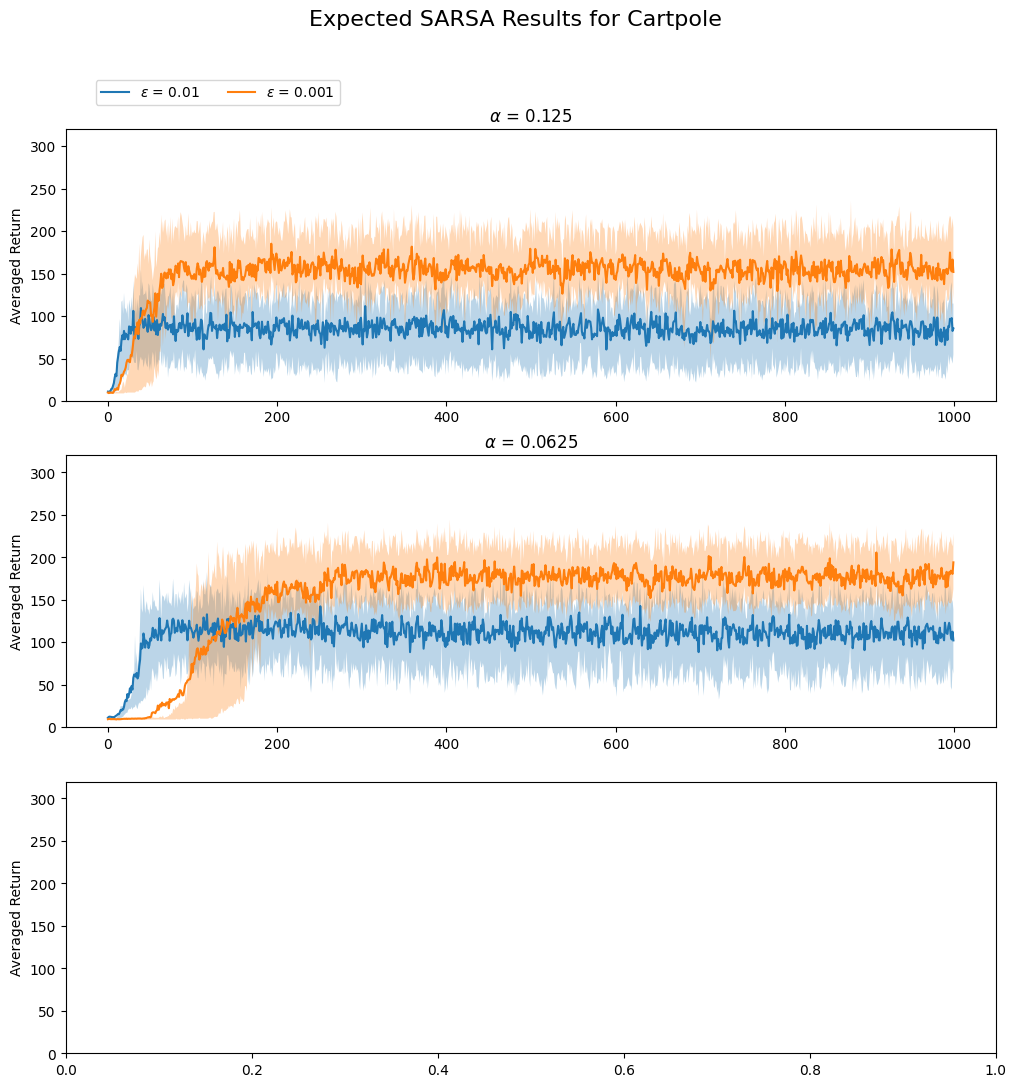

In [10]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(12, 12))

#print(learning_return[0])

plt.rcParams["figure.figsize"]=10,5

for i, learning in enumerate(CP_epsilon_return_SARSA):

  for j, alpha_data in enumerate(learning):
    ar_1_mean = np.mean(alpha_data, axis = 0)
    par_1_75, par_1_25 = np.percentile(alpha_data, [75, 25], axis = 0)
    if i == 0:
      axs[i].plot(range(episodes), ar_1_mean, label = f'${{\\epsilon}}$ = {epsilon[j]}')
    else:
      axs[i].plot(range(episodes), ar_1_mean)
    axs[i].set_title(f'${{\\alpha}}$ = {alpha[i]}')
    axs[i].fill_between(range(episodes), par_1_25, par_1_75, alpha=0.3)

plt.setp(axs, ylim=[0, 320], ylabel = 'Averaged Return')
fig.suptitle('Expected SARSA Results for Cartpole', fontsize = 16)

fig.legend(bbox_to_anchor=(0.15, 0.9, 1., .102), loc='lower left',
                      ncol=3, borderaxespad=0.)

In [5]:
env = gym.make('MountainCar-v0')
obs = env.reset()

epsilon = [0.01, 0.001]
bins = 15
num_tiles = 2
alpha = [1/8, 1/16]
trials = 50
gamma = 0.99
episodes = 1000

In [6]:
MC_epsilon_return_SARSA = []
for j in range(len(alpha)):
  learning_return_SARSA = []
  for a in range(len(epsilon)):
    avg_return = Expected_SARSA_implement(env,  tilecoding_Mountain(env,num_tiles, bins), alpha[j], epsilon[a], num_tiles, bins)
    learning_return_SARSA.append(avg_return)
  MC_epsilon_return_SARSA.append(learning_return_SARSA)

/Users/alanyang/Library/Python/3.9/lib/python/site-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [10]:
pkl_path = './Expected_SARSA_TC/MC/'
os.makedirs(pkl_path, exist_ok=True)

dataStore = {}
for i, learning in enumerate(MC_epsilon_return_SARSA):
    dataStore[alpha[i]] = {}
    for j, alpha_data in enumerate(learning):
        dataStore[alpha[i]][epsilon[j]] = alpha_data
    
with open('Results_ES_MC_TC_2.pkl', 'wb') as fp:
        pickle.dump(dataStore, fp)
        print('dictionary saved successfully to file')

dictionary saved successfully to file


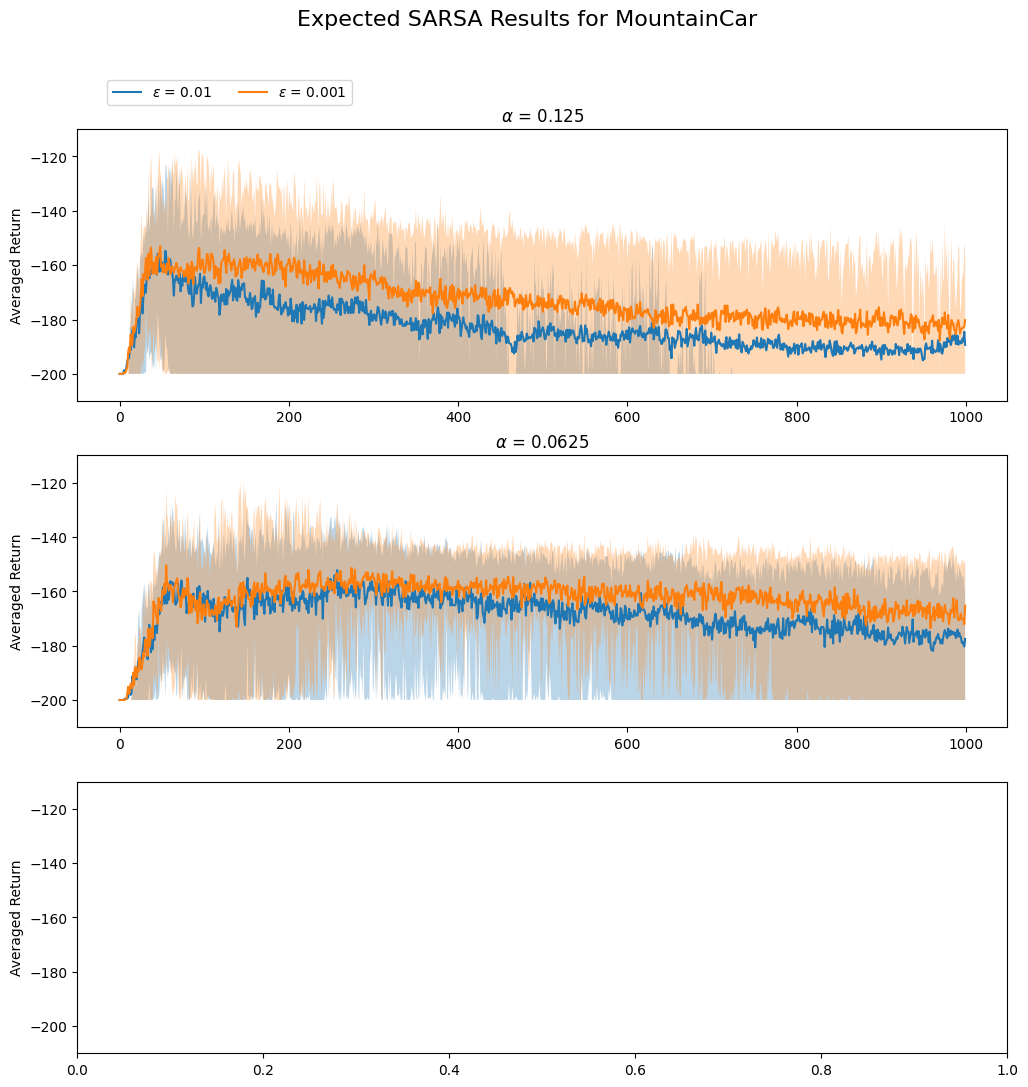

In [8]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(12, 12))

#print(learning_return[0])

plt.rcParams["figure.figsize"]=10,5

for i, learning in enumerate(MC_epsilon_return_SARSA):

  for j, alpha_data in enumerate(learning):
    ar_1_mean = np.mean(alpha_data, axis = 0)
    par_1_75, par_1_25 = np.percentile(alpha_data, [75, 25], axis = 0)
    if i == 0:
      axs[i].plot(range(episodes), ar_1_mean, label = f'${{\\epsilon}}$ = {epsilon[j]}')
    else:
      axs[i].plot(range(episodes), ar_1_mean)
    axs[i].set_title(f'${{\\alpha}}$ = {alpha[i]}')
    axs[i].fill_between(range(episodes), par_1_25, par_1_75, alpha=0.3)

plt.setp(axs, ylim=[-210, -110], ylabel = 'Averaged Return')
fig.suptitle('Expected SARSA Results for MountainCar', fontsize = 16)

fig.legend(bbox_to_anchor=(0.15, 0.9, 1., .102), loc='lower left',
           ncol=3, borderaxespad=0.)

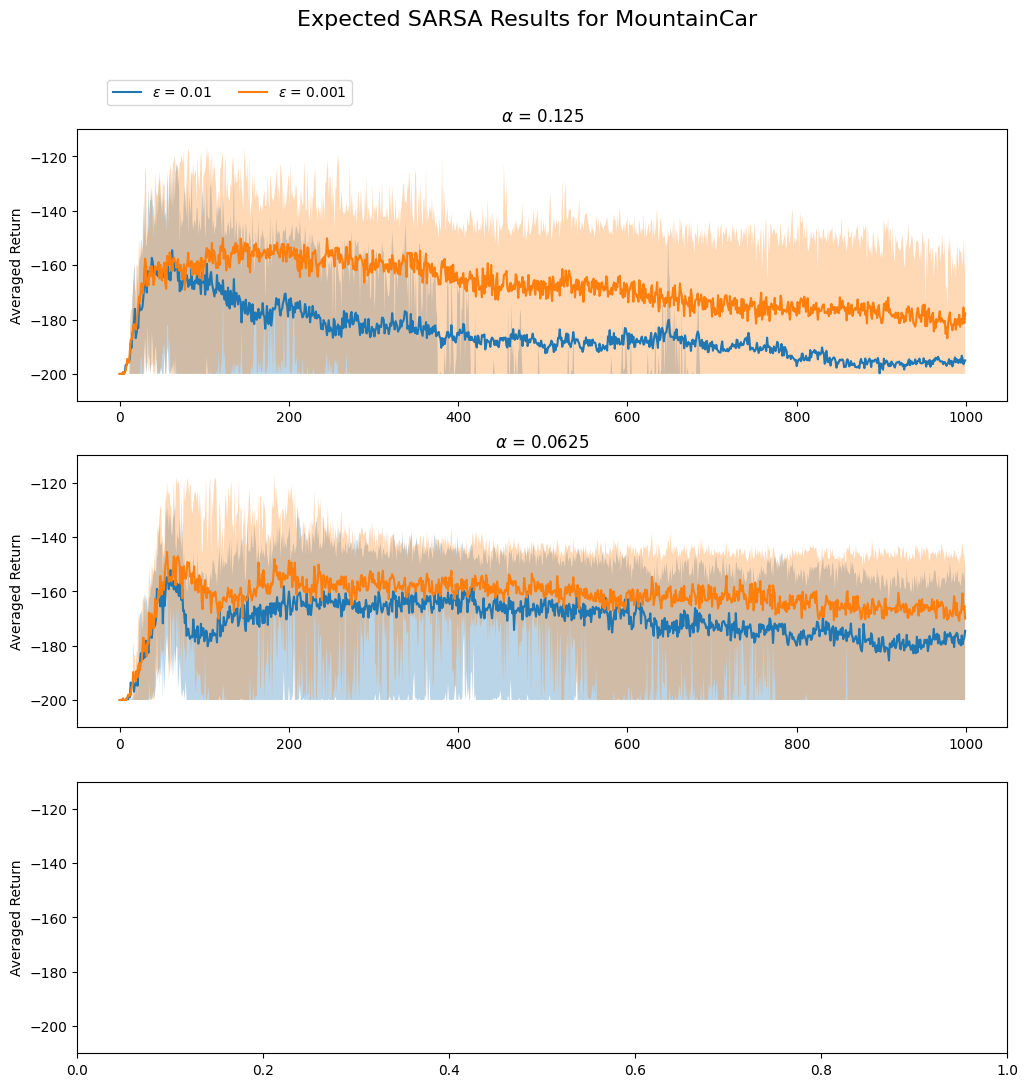

In [11]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(12, 12))

#print(learning_return[0])

plt.rcParams["figure.figsize"]=10,5

for i, learning in enumerate(MC_epsilon_return_SARSA):

  for j, alpha_data in enumerate(learning):
    ar_1_mean = np.mean(alpha_data, axis = 0)
    par_1_75, par_1_25 = np.percentile(alpha_data, [75, 25], axis = 0)
    if i == 0:
      axs[i].plot(range(episodes), ar_1_mean, label = f'${{\\epsilon}}$ = {epsilon[j]}')
    else:
      axs[i].plot(range(episodes), ar_1_mean)
    axs[i].set_title(f'${{\\alpha}}$ = {alpha[i]}')
    axs[i].fill_between(range(episodes), par_1_25, par_1_75, alpha=0.3)

plt.setp(axs, ylim=[-210, -110], ylabel = 'Averaged Return')
fig.suptitle('Expected SARSA Results for MountainCar', fontsize = 16)

fig.legend(bbox_to_anchor=(0.15, 0.9, 1., .102), loc='lower left',
                      ncol=3, borderaxespad=0.)